In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from keras.models import Sequential
from keras.layers import *
from keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

sns.set_theme(rc={'figure.figsize':(16,8)})

def plot_confusion_matrix(Y_test, predicted):
    predicted = tf.squeeze(predicted)
    predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
    actual = np.array(Y_test)
    conf_mat = confusion_matrix(actual, predicted)
    displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    displ.plot()


def my_read_data(scale=False):
    # Reads already cleaned data from .csv, scales if specified and returns X, Y values.

    file_path_train = Path('adults_data','adults_imputed_train_data.csv')
    file_path_test = Path('adults_data','adults_imputed_test_data.csv')

    df_train = pd.read_csv(file_path_train)
    df_test = pd.read_csv(file_path_test)

    X_train = df_train.iloc[:,:-1]
    X_test = df_test.iloc[:,:-1]
    X_train = pd.get_dummies(X_train, dtype=float)
    X_test = pd.get_dummies(X_test, dtype=float)
    
    Y_train = df_train.iloc[:,-1]
    Y_test = df_test.iloc[:,-1]

    Y_train = Y_train.replace("<=50K", 0)
    Y_train = Y_train.replace(">50K", 1)
    Y_test = Y_test.replace("<=50K", 0)
    Y_test = Y_test.replace(">50K", 1)

    if scale: pass

    return X_train, X_test, Y_train, Y_test


def balance_data(X_train, Y_train, type="ros"):

    if type == "ros":
        ros = RandomOverSampler(random_state=5)
        X_train, Y_train = ros.fit_resample(X_train, Y_train)
    elif type == "smote":
        smote = SMOTE(random_state=5, k_neighbors=5)
        X_train, Y_train = smote.fit_resample(X_train, Y_train)
    else:
        print("Balancing type not found")

    return X_train, Y_train

* scaling
* train test split
* oversampling

In [17]:
def classification_rnn(epochs=300, batch_size=15, scale=False, balance_type=None):

    X_train, X_test, Y_train, Y_test = my_read_data(scale)

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    # Build
    model = Sequential()
    model.add(Dense(64, "relu", input_shape=(66,)))
    #model.add(Dense(16, "relu"))
    model.add(Dense(1, 'sigmoid'))

    # Compile 
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=Adam(learning_rate=0.0008))
    model.summary()

    # Fit & Predict
    model_fit = model.fit(X_train, Y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)    
    predictions_rnn = model.predict(X_test)

    # tresholding
    predictions_rnn = np.where(predictions_rnn >= 0.5, 1, 0)

    # Get accuracy
    train_accuracy = model_fit.history['accuracy']
    val_accuracy = model_fit.history['val_accuracy']


    # Plot accuracy
    epochs = range(1, len(train_accuracy) + 1)
    plt.ylim(0,1)
    plt.plot(epochs, train_accuracy, label="Training set")
    plt.plot(epochs, val_accuracy, label="Validation set")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print("Accuracy: ", accuracy_score(Y_test, predictions_rnn))
    print("F1 Score: ", f1_score(Y_test, predictions_rnn))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_rnn))

    cm = ConfusionMatrixDisplay.from_predictions(Y_test, predictions_rnn) 
    cm.ax_.set_title("Confusion matrix for Neural Network Classification")
    plt.show()

In [18]:
def classification_lr(scale=False, balance_type=None):
    
    X_train, X_test, Y_train, Y_test = my_read_data(scale)

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_lr = LogisticRegression().fit(X_train, Y_train)
    predictions_lr = model_lr.predict(X_test)
    
    
    print("Accuracy: ", accuracy_score(Y_test, predictions_lr))
    print("F1 Score: ", f1_score(Y_test, predictions_lr))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_lr))

    cm = ConfusionMatrixDisplay.from_estimator(model_lr, X_test, Y_test) 
    cm.ax_.set_title("Confusion matrix for Logistic Regression Classification")
    plt.show()

In [19]:
def classification_xgb(scale=False, balance_type=None):

    X_train, X_test, Y_train, Y_test = my_read_data(scale)

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_xgb = xgb.XGBClassifier()

    # fit & predict
    model_xgb.fit(X_train, Y_train)
    predictions_xgb = model_xgb.predict(X_test)


    print("Accuracy:", accuracy_score(Y_test, predictions_xgb))
    print("F1 Score: ", f1_score(Y_test, predictions_xgb))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_xgb))

    cm_im = ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, Y_test) 
    cm_im.ax_.set_title("Confusion matrix for XGBoost Classification")
    plt.show()

In [20]:
def classification_knn(scale=False, balance_type=None, grid=False):

    X_train, X_test, Y_train, Y_test = my_read_data(scale)

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)


    param_grid = {'n_neighbors': np.arange(1, 11),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}

    model_knn = KNeighborsClassifier()


    if grid:
        # Define & fit grid search
        grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train, Y_train)

        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best F1 score:", grid_search.best_score_)

        # Define best model
        model_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                    weights=grid_search.best_params_['weights'],
                                    algorithm=grid_search.best_params_['algorithm'],
                                    p=grid_search.best_params_['p'])

    # fit & predict
    model_knn.fit(X_train, Y_train)
    predictions_knn = model_knn.predict(X_test)


    print("Accuracy:", accuracy_score(Y_test, predictions_knn))
    print("F1 Score: ", f1_score(Y_test, predictions_knn))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_knn))

    cm_im = ConfusionMatrixDisplay.from_estimator(model_knn, X_test, Y_test) 
    cm_im.ax_.set_title("Confusion matrix for KNN Classification")
    plt.show()

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best F1 score: 0.8923095016358025
Accuracy: 0.9476141867384836
F1 Score:  0.8945527673340911

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     34621
           1       0.89      0.90      0.89     11422

    accuracy                           0.95     46043
   macro avg       0.93      0.93      0.93     46043
weighted avg       0.95      0.95      0.95     46043



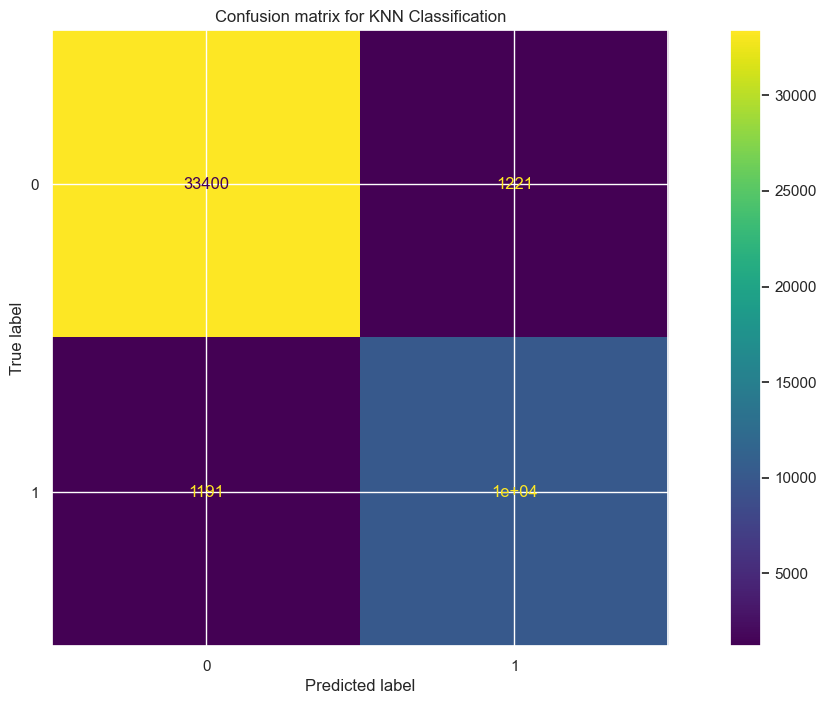

In [22]:
classification_knn(balance_type="ros", grid=True)

In [ ]:
classification_xgb(scale=False, balance_type="ros")

In [ ]:
classification_lr(scale=False, balance_type="ros")

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 64)                4288      
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4353 (17.00 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
1356/1356 [==============================] - 2s 1ms/step - loss: 221.2068 - accuracy: 0.6553 - val_loss: 49.5421 - val_accuracy: 0.2535
Epoch 2/300
1356/1356 [==============================] - 1s 1ms/step - loss: 86.7872 - accuracy: 0.6669 - val_loss: 43.2696 - val_accuracy: 0.7780
Epoch 3/300
1356/1356 [==============================] - 1s 1ms/step - loss: 70.1203 - accuracy: 0.6742 - val_loss: 66.5

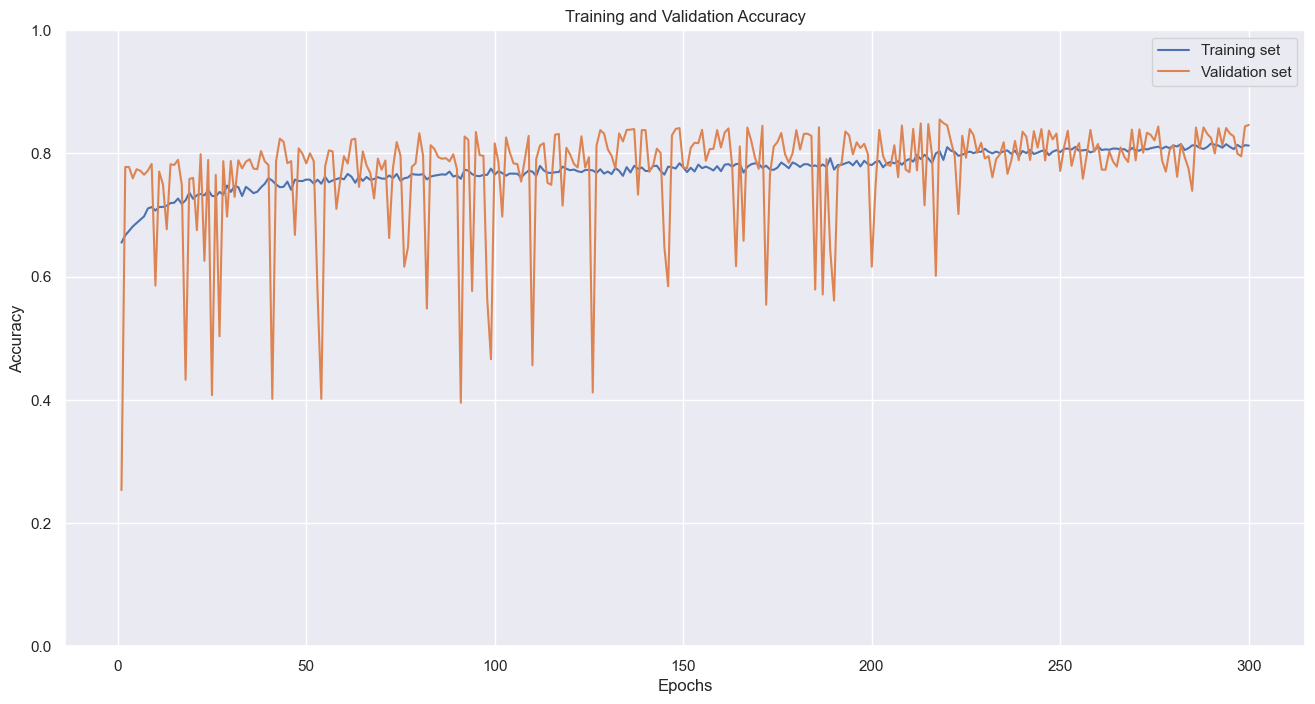

Accuracy:  0.8366766967569375

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4558
           1       0.68      0.60      0.64      1424

    accuracy                           0.84      5982
   macro avg       0.78      0.76      0.77      5982
weighted avg       0.83      0.84      0.83      5982



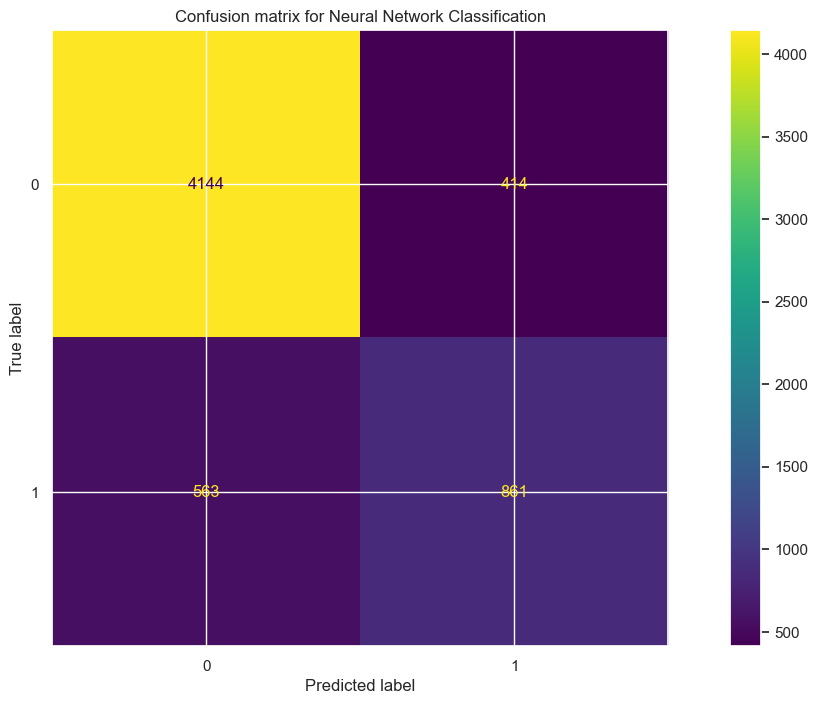

In [131]:
classification_rnn()